In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf

In [2]:
df = pd.read_parquet('../final_data/final_data_v1.parquet').drop(['timestamp','location'],axis=1)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df_p0 = df[0:int(n*0.7)].drop(['P1','P2'],axis=1)
val_df_p0 = df[int(n*0.7):int(n*0.9)].drop(['P1','P2'],axis=1)
test_df_p0 = df[int(n*0.9):].drop(['P1','P2'],axis=1)

train_df_p1 = df[0:int(n*0.7)].drop(['P0','P2'],axis=1)
val_df_p1 = df[int(n*0.7):int(n*0.9)].drop(['P0','P2'],axis=1)
test_df_p1 = df[int(n*0.9):].drop(['P0','P2'],axis=1)

train_df_p2 = df[0:int(n*0.7)].drop(['P1','P0'],axis=1)
val_df_p2 = df[int(n*0.7):int(n*0.9)].drop(['P1','P0'],axis=1)
test_df_p2 = df[int(n*0.9):].drop(['P1','P0'],axis=1)

print(train_df_p0)

         lat     lon  humidity  temperature     P0   Day sin  Year sin
50407 -1.292  36.821      63.7         25.1   7.00  0.594823  0.948590
50412 -1.292  36.821      63.1         24.5   7.00  0.584250  0.948579
67637 -1.292  36.821      64.3         25.3   4.00  0.354291  0.895866
67642 -1.292  36.821      63.2         25.6   3.00  0.346117  0.895856
67647 -1.292  36.821      66.8         24.8   3.40  0.333807  0.895840
...      ...     ...       ...          ...    ...       ...       ...
17617 -1.270  36.801      47.0         23.6  14.75 -0.923880  0.929294
17621 -1.270  36.801      47.3         23.6  14.40 -0.928810  0.929307
17628 -1.270  36.801      47.9         23.5  16.00 -0.938191  0.929334
17632 -1.270  36.801      48.2         23.4  17.50 -0.941176  0.929342
17641 -1.270  36.801      48.8         23.3  13.60 -0.949699  0.929369

[928891 rows x 7 columns]


In [15]:
train_mean_p0 = train_df_p0.mean()
train_std_p0 = train_df_p0.std()

train_df_p0 = (train_df_p0 - train_mean_p0) / train_std_p0
val_df_p0 = (val_df_p0 - train_mean_p0) / train_std_p0
test_df_p0 = (test_df_p0 - train_mean_p0) / train_std_p0

train_mean_p1 = train_df_p1.mean()
train_std_p1 = train_df_p1.std()

train_df_p1 = (train_df_p1 - train_mean_p1) / train_std_p1
val_df_p1 = (val_df_p1 - train_mean_p1) / train_std_p1
test_df_p1 = (test_df_p1 - train_mean_p1) / train_std_p1

train_mean_p2 = train_df_p2.mean()
train_std_p2 = train_df_p2.std()

train_df_p2 = (train_df_p2 - train_mean_p2) / train_std_p2
val_df_p2 = (val_df_p2 - train_mean_p2) / train_std_p2
test_df_p2 = (test_df_p2 - train_mean_p2) / train_std_p2



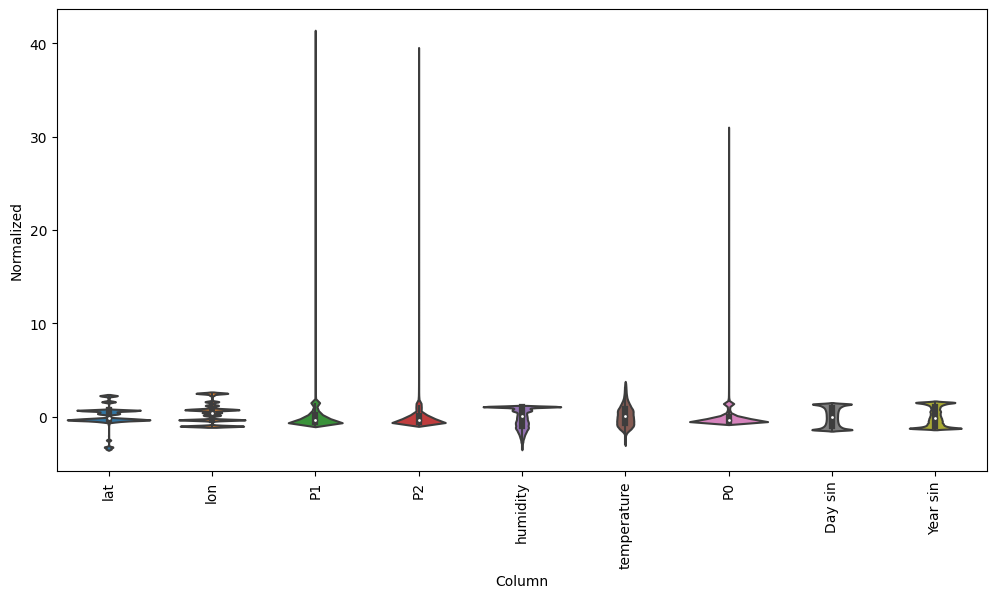

In [16]:
df_std_p0 = (df - train_mean_p0) / train_std_p0
df_std = df_std_p0.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [5]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [7]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1, train_df=train_df_p0, val_df=val_df_p0,test_df=test_df_p0,label_columns=['P0'])
print(w1)

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['P0']


In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df_p0[:w1.total_window_size]),
                           np.array(train_df_p0[100:100+w1.total_window_size]),
                           np.array(train_df_p0[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
Labels shape: (3, 1, 1)


In [11]:
w1.example = example_inputs, example_labels

In [12]:
def plot(self, model=None, plot_col='P0', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

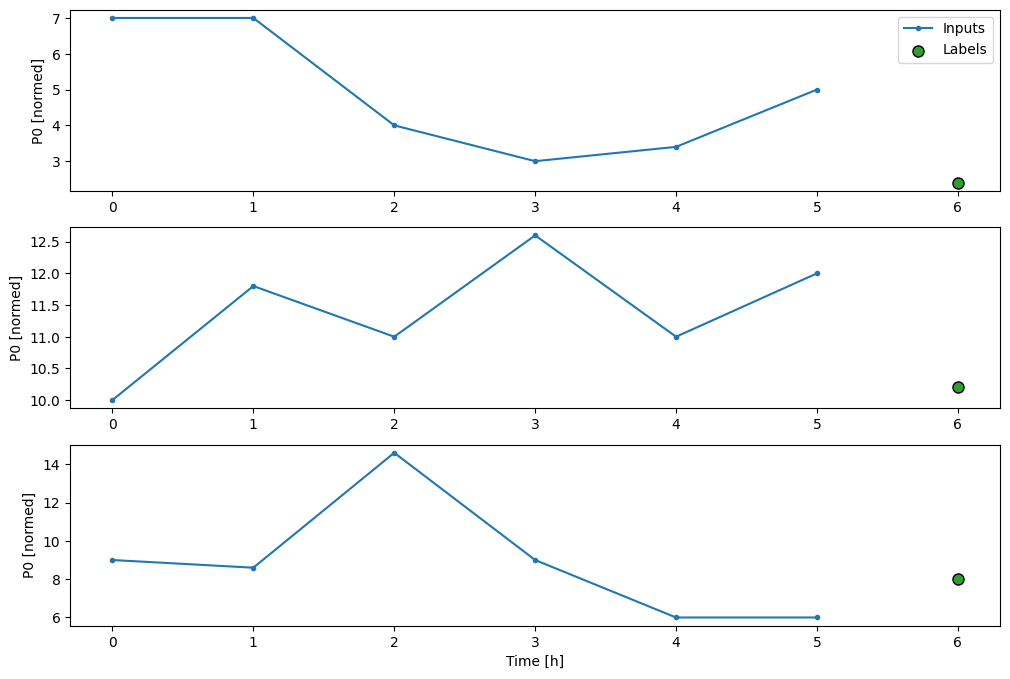

In [13]:
w1.plot()

In [14]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [17]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [18]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['P0'], train_df=train_df_p0,val_df=val_df_p0,test_df=test_df_p0)
print(single_step_window)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['P0']


In [19]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [20]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [21]:
baseline = Baseline(label_index=column_indices['P0'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8294/8294 [==============================] - 17s 2ms/step - loss: 342.9857 - mean_absolute_error: 14.7727


In [24]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, train_df=train_df_p0,val_df=val_df_p0,test_df=test_df_p0,label_columns=['P0'])

print(wide_window)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['P0']


In [25]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


In [ ]:
baseline = Baseline(label_index=column_indices['P0'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

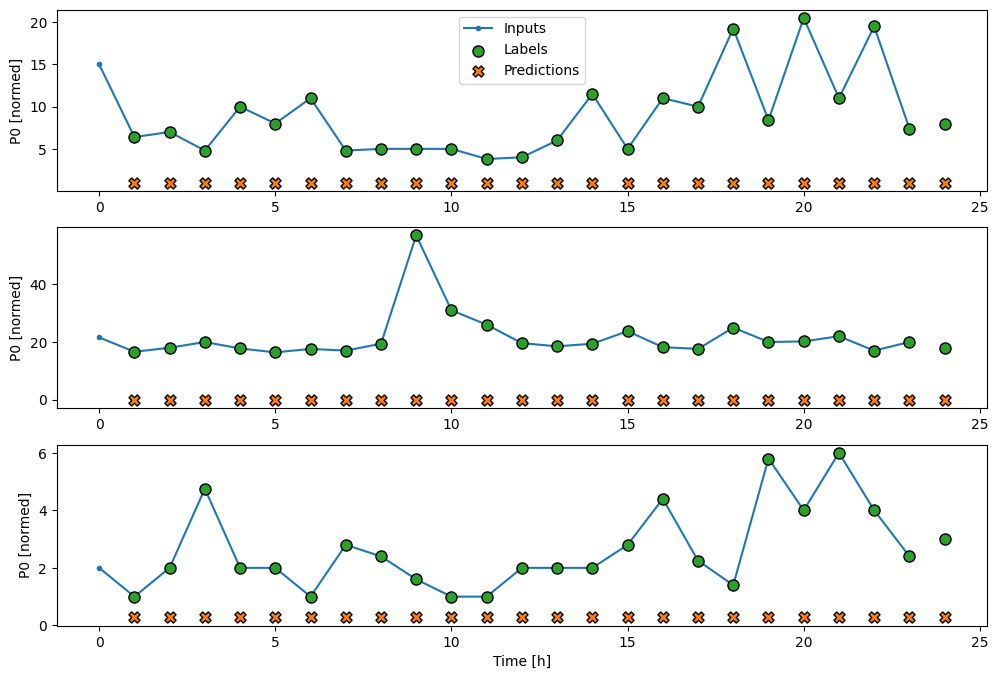

In [26]:
wide_window.plot(baseline)